# Opening a SNiPER userfile

In [1]:
import orsa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

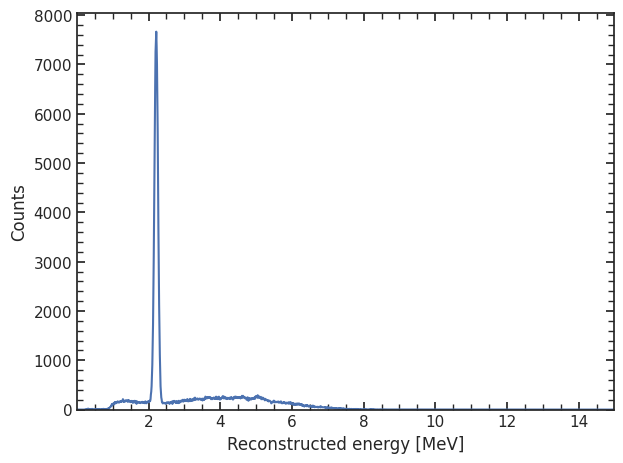

In [2]:
reco = orsa.sniper.load_userfile('../tests/common_files/reactor_userfile.root').to_list()

bins = np.arange(0, 15, 0.01)
reco.to_hist(bins)

In [3]:
promptlist, delayedlist = orsa.selection.standard(reco)

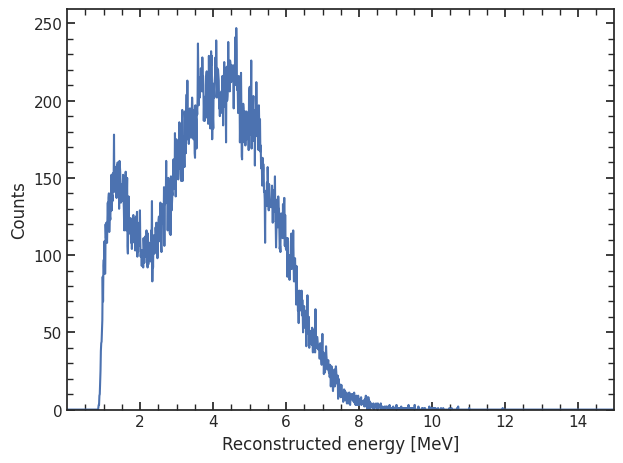

In [4]:
promptlist.to_hist(bins)

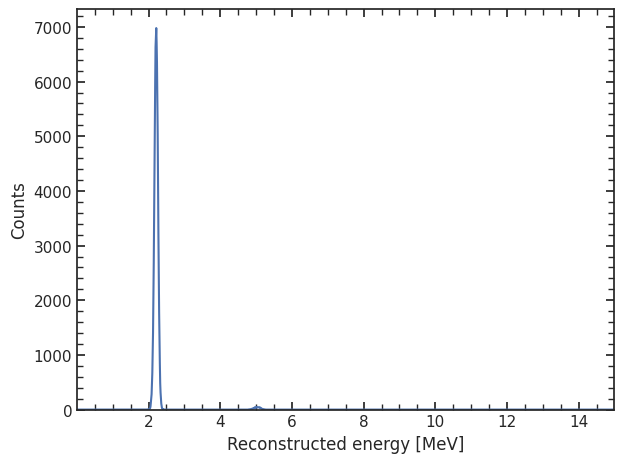

In [5]:
delayedlist.to_hist(bins)

## Let's try a fit

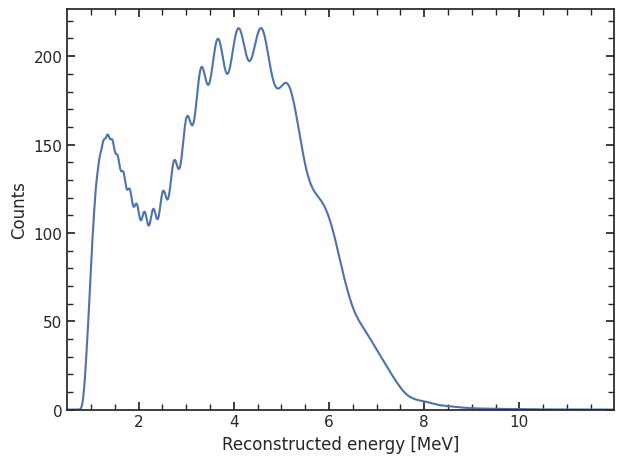

In [6]:
model = orsa.model.Model([], np.arange(0.5, 12, 0.01), 0.8, 11, orsa.oscillation.default(), orsa.detector.default(), False, False, False, rebin = 1, exposure = 1)

model.add_parameter(orsa.model.DetectorParameter(label = 'eff', value = 1,          error = 0.01,   prior = {'positive': None},   formatted_label = r'$\epsilon$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'a',   value = 0.02614,    error = 0.0077, prior = {'positive': None},   formatted_label = r'$a$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'b',   value = 0.006401,   error = 0.012,  prior = {'positive': None},   formatted_label = r'$b$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'c',   value = 0.01205,    error = 0.033,  prior = {'positive': None},   formatted_label = r'$c$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'a0',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_0$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'a1',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_1$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'a2',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_2$'))
model.add_parameter(orsa.model.DetectorParameter(label = 'a3',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_3$'))

model.add_parameter(orsa.model.OscillationParameter(label = 'rho',      value = 2.45,       error = 0.06,   prior = {'positive': None}, formatted_label = r'$\rho$'))
model.add_parameter(orsa.model.OscillationParameter(label = 'dm2_21',   value = 7.53e-5,    error = np.inf,                       formatted_label = r'$\Delta m^2_{21}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 'dm2_31',   value = 2.5283e-3,  error = np.inf,                       formatted_label = r'$\Delta m^2_{31}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 's2_12',    value = 0.307,      error = np.inf,                       formatted_label = r'$\sin^2 \theta_{12}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 's2_13',    value = 0.0218,     error = np.inf,                       formatted_label = r'$\sin^2 \theta_{13}$'))

# norm_scale = 6*365.25 # 6 years
shape_fact = np.sqrt(36e-03/model.bin)
shape_fact_20 = np.sqrt(20e-03/model.bin)

gen_dict = dict()
gen_dict['rea'] = orsa.generator.sniper('reactors', True, shape_uncertainty='tao')

model.add_parameter(orsa.model.NormalizationParameter(label = 'rea',   value = promptlist.n,    generator = gen_dict['rea'],     error = 0.02,     is_oscillated=True, has_duty=False,      formatted_label = r'$N_\mathrm{rea}$'))

asimov = model.get_spectrum(asimov = True).to_hist()
asimov

In [7]:
init_model = model.copy()
data_hist = promptlist.to_hist(asimov.Eedges)
min_func_bin = orsa.probability.CostFunction(ll=orsa.probability.chi2, ll_args=dict(data=data_hist))
model.use_shape_uncertainty = False
res = orsa.fit.minuit(model, min_func_bin)

Cost function parsed as chi2-like


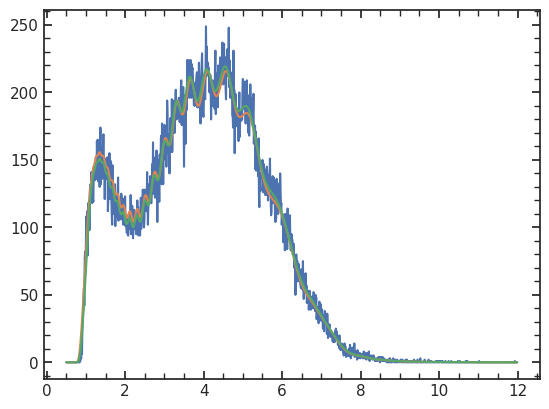

In [8]:
sp0 = init_model.get_spectrum(asimov=True)
sp1 = model.get_spectrum(asimov=True)

plt.plot(data_hist.E, data_hist.counts)
plt.plot(sp0.E, sp0.counts)
plt.plot(sp1.E, sp1.counts)

(0.0, 280.0)

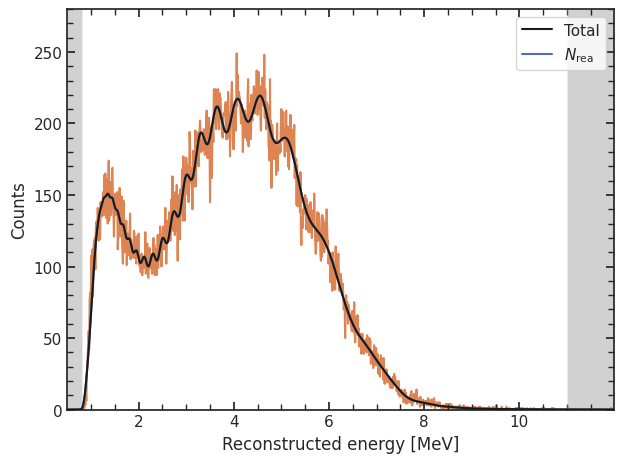

In [9]:
fig, ax = model.get_fig()
ax.plot(data_hist.E, data_hist.counts, zorder = -10)
ax.set_ylim(top = 280)

In [10]:
res.obj

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 895.4                      │              Nfcn = 658              │
│ EDM = 5.28e-05 (Goal: 0.0002)    │            time = 3.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ eff    │  1.0005   │  0.0024   │            │            │         │         │       │
│ 1 │ a      │ 26.12e-3  │  0.13e-3  │            │            │         │         │       │
│ 2 │ b      │  6.40e-3  │  0.05e-3  │            │            │         │         │       │
│ 3 │ c      │ 12.00e-3  │  0.26e-3  │            │            │         │         │       │
│ 4 │ a0     │   -0.6    │    0.4    │            │            │         │         │       │
│ 5 │ a1     │   -1.06   │   0.20    │            │            │         │         │       │
│ 6 │ a2     │    0.7    │    2.6    │            │            │         │         │       │
│ 7 │ a3     │    2.1    │    2.3    │            │            │         │         │       │
│ 8 │ rho    │   2.45    │   0.09    │            │            │         │         │       │
│ 9 │ dm2_21 │ 74.53e-6  │  0.09e-6  │            │            │         │         │       │
│ 10│ dm2_31 │ 2.5122e-3 │ 0.0027e-3 │            │            │         │         │       │
│ 11│ s2_12  │ 310.7e-3  │  0.6e-3   │            │            │         │         │       │
│ 12│ s2_13  │  20.3e-3  │  1.0e-3   │            │            │         │         │       │
│ 13│ rea    │  277.9e3  │   0.7e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │            eff              a              b              c             a0             a1             a2             a3            rho         dm2_21         dm2_31          s2_12          s2_13            rea │
├────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    eff │       5.57e-06      -0.001e-6              0             -0         -80e-6         -39e-6         968e-6        -847e-6          -8e-6     29.986e-12       -163e-12        0.31e-6         0.4e-6    -373.719e-3 │
│      a │      -0.001e-6       1.68e-08             -0             -0       0.685e-6       0.330e-6      -9.770e-6       8.585e-6       0.021e-6       -191e-15          1e-12      -0.001e-6       0.002e-6    -202.281e-6 │
│      b │              0             -0       2.45e-09             -0        31.7e-9        16.9e-9      -463.3e-9       406.5e-9         1.1e-9        -10e-15          0e-12        -0.1e-9         0.2e-9      8.8565e-6 │
│      c │             -0             -0             -0       6.53e-08      

  1%|          | 12/1000 [00:00<00:08, 117.08it/s]

100%|██████████| 1000/1000 [00:09<00:00, 106.24it/s]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

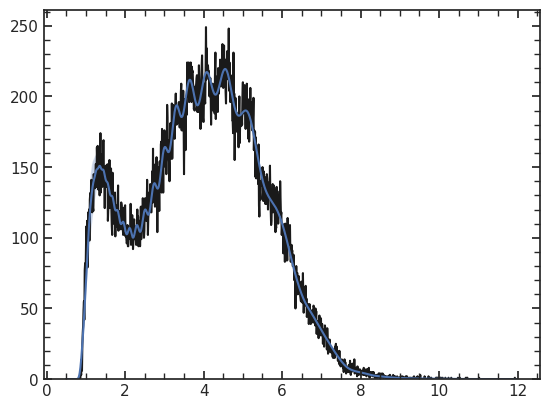

In [11]:
res.get_samples(10000)

fig, ax = plt.subplots()
ax.plot(promptlist.to_hist(asimov.Eedges).E, promptlist.to_hist(asimov.Eedges).counts, 'k-', zorder = -1)
orsa.plot.model_ci(res, 1000, [3], ax = ax)

In [12]:
# min_func_bin = orsa.probability.CostFunction(ll=orsa.probability.chi2, ll_args=dict(data=data_hist))

min_func_unb = orsa.probability.CostFunction(ll=orsa.probability.ll_unbinned, ll_args=dict(data=promptlist))

min_func_unb.lp_args = min_func_bin.lp_args

m_res_unb = orsa.fit.minuit(model, min_func_unb, res.model)

Cost function parsed as LogLikelihood-like


(<Figure size 1000x600 with 14 Axes>,
 array([<Axes: title={'center': '$\\epsilon$'}>,
        <Axes: title={'center': '$a$'}>, <Axes: title={'center': '$b$'}>,
        <Axes: title={'center': '$c$'}>,
        <Axes: title={'center': '$a^{nl}_0$'}>,
        <Axes: title={'center': '$a^{nl}_1$'}>,
        <Axes: title={'center': '$a^{nl}_2$'}>,
        <Axes: title={'center': '$a^{nl}_3$'}>,
        <Axes: title={'center': '$\\rho$'}>,
        <Axes: title={'center': '$\\Delta m^2_{21}$'}>,
        <Axes: title={'center': '$\\Delta m^2_{31}$'}>,
        <Axes: title={'center': '$\\sin^2 \\theta_{12}$'}>,
        <Axes: title={'center': '$\\sin^2 \\theta_{13}$'}>,
        <Axes: title={'center': '$N_\\mathrm{rea}$'}>, <Axes: >],
       dtype=object))

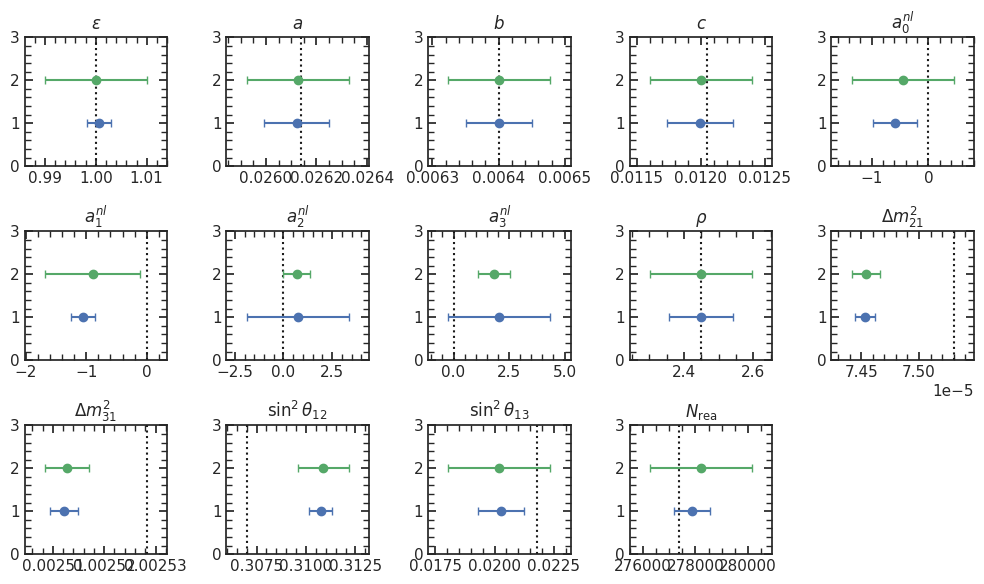

In [13]:
orsa.plot.bars([res, m_res_unb], true_values=True)